In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/noise-dataset/drdo/clean_avg_fixed/p228_007.wav
/kaggle/input/noise-dataset/drdo/clean_avg_fixed/p227_162.wav
/kaggle/input/noise-dataset/drdo/clean_avg_fixed/p226_302.wav
/kaggle/input/noise-dataset/drdo/clean_avg_fixed/p227_303.wav
/kaggle/input/noise-dataset/drdo/clean_avg_fixed/p227_113.wav
/kaggle/input/noise-dataset/drdo/clean_avg_fixed/p228_138.wav
/kaggle/input/noise-dataset/drdo/clean_avg_fixed/p228_050.wav
/kaggle/input/noise-dataset/drdo/clean_avg_fixed/p227_069.wav
/kaggle/input/noise-dataset/drdo/clean_avg_fixed/p230_129.wav
/kaggle/input/noise-dataset/drdo/clean_avg_fixed/p230_236.wav
/kaggle/input/noise-dataset/drdo/clean_avg_fixed/p226_358.wav
/kaggle/input/noise-dataset/drdo/clean_avg_fixed/p231_101.wav
/kaggle/input/noise-dataset/drdo/clean_avg_fixed/p231_210.wav
/kaggle/input/noise-dataset/drdo/clean_avg_fixed/p230_372.wav
/kaggle/input/noise-dataset/drdo/clean_avg_fixed/p228_363.wav
/kaggle/input/noise-dataset/drdo/clean_avg_fixed/p231_134.wav
/kaggle/

In [ ]:
import os
import torch
import torch.nn as nn
import numpy as np
import librosa
import soundfile as sf
from glob import glob
from torch.utils.data import Dataset, DataLoader
from IPython.display import Audio, display, clear_output
from tqdm import tqdm

# === Config
sr = 16000
duration = 3.05
length = int(sr * duration)
n_fft = 512
hop_length = 256

# === Dataset
class STFTDataset(Dataset):
    def __init__(self, clean_files, noisy_files):
        self.clean_files = clean_files
        self.noisy_files = noisy_files

    def __len__(self):
        return len(self.clean_files)

    def __getitem__(self, idx):
        clean, _ = librosa.load(self.clean_files[idx], sr=sr)
        noisy, _ = librosa.load(self.noisy_files[idx], sr=sr)

        clean = librosa.util.fix_length(clean, size=length)
        noisy = librosa.util.fix_length(noisy, size=length)

        clean = clean / np.max(np.abs(clean))
        noisy = noisy / np.max(np.abs(noisy))

        # === STFT (return magnitude only)
        clean_stft = librosa.stft(clean, n_fft=n_fft, hop_length=hop_length)
        noisy_stft = librosa.stft(noisy, n_fft=n_fft, hop_length=hop_length)

        clean_mag = np.abs(clean_stft)
        noisy_mag = np.abs(noisy_stft)

        return torch.tensor(noisy_mag).float(), torch.tensor(clean_mag).float()


In [ ]:
class STFTDenoiser(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 16, 3, padding=1), nn.ReLU(),
            nn.Conv2d(16, 1, 3, padding=1)  # Final single-channel output
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
# File paths
clean_dir = "/kaggle/input/noise-dataset/drdo/clean_avg_fixed"
noisy_dir = "/kaggle/input/noise-dataset/drdo/mixed_dataset/noisy"
clean_files = sorted(glob(f"{clean_dir}/*.wav"))
noisy_files = sorted(glob(f"{noisy_dir}/*.wav"))

dataset = STFTDataset(clean_files, noisy_files)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = STFTDenoiser().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

for epoch in range(10):
    model.train()
    total_loss = 0
    for noisy, clean in tqdm(loader, desc=f"Epoch {epoch+1}"):
        noisy = noisy.unsqueeze(1).to(device)  # (B, 1, F, T)
        clean = clean.unsqueeze(1).to(device)

        output = model(noisy)
        loss = loss_fn(output, clean)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"✅ Epoch {epoch+1} | Avg Loss: {total_loss / len(loader):.4f}")


In [ ]:
# Load test audio
test_audio, _ = librosa.load(noisy_files[0], sr=sr)
test_audio = librosa.util.fix_length(test_audio, size=length)
test_audio = test_audio / np.max(np.abs(test_audio))

# STFT
test_stft = librosa.stft(test_audio, n_fft=n_fft, hop_length=hop_length)
test_mag = np.abs(test_stft)
test_phase = np.angle(test_stft)

# Predict
model.eval()
test_tensor = torch.tensor(test_mag).unsqueeze(0).unsqueeze(0).to(device)

with torch.no_grad():
    denoised_mag = model(test_tensor).squeeze().cpu().numpy()

# Reconstruct complex spectrogram
reconstructed_stft = denoised_mag * np.exp(1j * test_phase)
reconstructed_audio = librosa.istft(reconstructed_stft, hop_length=hop_length)

# Save and play
sf.write("stft_denoised.wav", reconstructed_audio, sr)
print("🎧 Denoised output saved!")
display(Audio("stft_denoised.wav", rate=sr))


In [ ]:
# ✅ 1. Imports
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import librosa
import numpy as np
import soundfile as sf
from glob import glob
from tqdm import tqdm
from IPython.display import Audio, display

# ✅ 2. Config
sr = 16000
duration = 3.05
length = int(sr * duration)
n_fft = 512
hop_length = 128
win_length = 512

# ✅ 3. Helper - STFT magnitude
def audio_to_mag(filepath):
    y, _ = librosa.load(filepath, sr=sr)
    y = librosa.util.fix_length(data=y, size=length)
    y = y / np.max(np.abs(y))
    stft = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
    mag = np.abs(stft)
    return mag.astype(np.float32)

# ✅ 4. Dataset
class SpectrogramDataset(Dataset):
    def __init__(self, clean_files, noisy_files):
        self.clean_files = clean_files
        self.noisy_files = noisy_files

    def __len__(self):
        return len(self.clean_files)

    def __getitem__(self, idx):
        clean_mag = audio_to_mag(self.clean_files[idx])
        noisy_mag = audio_to_mag(self.noisy_files[idx])
        return torch.tensor(noisy_mag).unsqueeze(0), torch.tensor(clean_mag).unsqueeze(0)

# ✅ 5. U-Net Model
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = nn.Sequential(nn.Conv2d(1, 16, 3, padding=1), nn.ReLU())
        self.enc2 = nn.Sequential(nn.Conv2d(16, 32, 3, padding=1), nn.ReLU())
        self.enc3 = nn.Sequential(nn.Conv2d(32, 64, 3, padding=1), nn.ReLU())
        self.middle = nn.Sequential(nn.Conv2d(64, 128, 3, padding=1), nn.ReLU())
        self.dec3 = nn.Sequential(nn.Conv2d(128, 64, 3, padding=1), nn.ReLU())
        self.dec2 = nn.Sequential(nn.Conv2d(64, 32, 3, padding=1), nn.ReLU())
        self.dec1 = nn.Sequential(nn.Conv2d(32, 16, 3, padding=1), nn.ReLU())
        self.final = nn.Conv2d(16, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(F.max_pool2d(e1, 2))
        e3 = self.enc3(F.max_pool2d(e2, 2))
        m = self.middle(F.max_pool2d(e3, 2))

        d3 = self.dec3(F.interpolate(m, size=e3.shape[-2:], mode='nearest'))
        d2 = self.dec2(F.interpolate(d3 + e3, size=e2.shape[-2:], mode='nearest'))
        d1 = self.dec1(F.interpolate(d2 + e2, size=e1.shape[-2:], mode='nearest'))
        out = self.final(d1 + e1)
        return out

# ✅ 6. File Paths
clean_dir = "/kaggle/input/noise-dataset/drdo/clean_avg_fixed"
noisy_dir = "/kaggle/input/noise-dataset/drdo/mixed_dataset/noisy"

clean_files = sorted(glob(f"{clean_dir}/*.wav"))
noisy_files = sorted(glob(f"{noisy_dir}/*.wav"))

# ✅ 7. Dataset + DataLoader
dataset = SpectrogramDataset(clean_files, noisy_files)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

# ✅ 8. Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# ✅ 9. Training
for epoch in range(10):
    model.train()
    total_loss = 0
    for noisy, clean in tqdm(loader, desc=f"Epoch {epoch+1}"):
        noisy, clean = noisy.to(device), clean.to(device)
        output = model(noisy)

        # Match shape
        min_h = min(output.shape[2], clean.shape[2])
        min_w = min(output.shape[3], clean.shape[3])
        output = output[:, :, :min_h, :min_w]
        clean = clean[:, :, :min_h, :min_w]

        loss = loss_fn(output, clean)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(loader)
    print(f"✅ Epoch {epoch+1} | Avg Loss: {avg_loss:.4f}")

# ✅ 10. Inference on one test sample
model.eval()
test_path = noisy_files[0]
test_y, _ = librosa.load(test_path, sr=sr)
test_y = librosa.util.fix_length(data=test_y, size=length)
test_y = test_y / np.max(np.abs(test_y))

test_stft = librosa.stft(test_y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
test_mag = np.abs(test_stft)
test_tensor = torch.tensor(test_mag).unsqueeze(0).unsqueeze(0).to(device)

with torch.no_grad():
    output_mag = model(test_tensor).cpu().squeeze().numpy()

# Match shape for reconstruction
output_mag = output_mag[:test_stft.shape[0], :test_stft.shape[1]]
phase = np.angle(test_stft[:, :output_mag.shape[1]])
reconstructed = output_mag * np.exp(1j * phase)
wav = librosa.istft(reconstructed, hop_length=hop_length, win_length=win_length)

# ✅ 11. Save and Play
sf.write("denoised_output.wav", wav, sr)
print("🎧 Denoised file saved: denoised_output.wav")
display(Audio("denoised_output.wav", rate=sr))


In [ ]:
# ✅ 12. DENOISE ANY NEW FILE (not from dataset)

def denoise_custom_noisy_file(input_path, output_path="custom_denoised.wav"):
    model.eval()

    # Load and normalize
    y, _ = librosa.load(input_path, sr=sr)
    y = librosa.util.fix_length(y, size=length)
    y = y / np.max(np.abs(y))

    # Convert to STFT
    stft = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
    mag = np.abs(stft)
    phase = np.angle(stft)

    # Predict
    tensor = torch.tensor(mag).unsqueeze(0).unsqueeze(0).to(device)
    with torch.no_grad():
        output_mag = model(tensor).cpu().squeeze().numpy()

    # Match shape
    output_mag = output_mag[:stft.shape[0], :stft.shape[1]]

    # Reconstruct
    reconstructed = output_mag * np.exp(1j * phase[:, :output_mag.shape[1]])
    denoised = librosa.istft(reconstructed, hop_length=hop_length, win_length=win_length)

    # Save
    sf.write(output_path, denoised, sr)
    print(f"✅ Saved: {output_path}")
    display(Audio(output_path, rate=sr))


# 🔹 Example Usage:
# Place any test file in your working dir and write the path
test_file_path = "/kaggle/input/noise-dataset/drdo/mixed_dataset/noisy/p226_014_explosion_radio.wav"  # 🧠 Replace with your test file name
denoise_custom_noisy_file(test_file_path, output_path="my_denoised.wav")


In [ ]:
import os

def folder_stats(folder_path):
    total_size = 0
    file_count = 0

    for root, dirs, files in os.walk(folder_path):
        for f in files:
            fp = os.path.join(root, f)
            total_size += os.path.getsize(fp)
            file_count += 1

    print(f"Folder: {folder_path}")
    print(f"Number of files: {file_count}")
    print(f"Total size: {total_size / (1024**2):.2f} MB")  # in MB

# Paths for your folders
clean_folder = "/kaggle/input/noise-dataset/drdo/clean_avg_fixed"
mixed_folder = "/kaggle/input/noise-dataset/drdo/mixed_dataset"

folder_stats(clean_folder)
folder_stats(mixed_folder)


In [ ]:
# Already computed: test_stft, output_mag
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(np.log1p(np.abs(test_stft)), aspect='auto', origin='lower')
plt.title("Noisy Spectrogram")

plt.subplot(1, 2, 2)
plt.imshow(np.log1p(output_mag), aspect='auto', origin='lower')
plt.title("Denoised Spectrogram")
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(12, 3))
plt.plot(test_y, label="Noisy", alpha=0.6)
plt.plot(wav, label="Denoised", alpha=0.8)
plt.title("Waveform: Noisy vs Denoised")
plt.xlabel("Sample")
plt.legend()
plt.grid(True)
plt.show()


Epoch 1: 100%|██████████| 473/473 [05:35<00:00,  1.41it/s]



✅ Epoch 1 | Avg Loss: 0.4067



Epoch 2: 100%|██████████| 473/473 [05:35<00:00,  1.41it/s]



✅ Epoch 2 | Avg Loss: 0.1297



Epoch 3: 100%|██████████| 473/473 [05:42<00:00,  1.38it/s]



✅ Epoch 3 | Avg Loss: 0.1072



Epoch 4: 100%|██████████| 473/473 [05:33<00:00,  1.42it/s]



✅ Epoch 4 | Avg Loss: 0.0967



Epoch 5: 100%|██████████| 473/473 [05:29<00:00,  1.43it/s]



✅ Epoch 5 | Avg Loss: 0.0881



Epoch 6: 100%|██████████| 473/473 [05:38<00:00,  1.40it/s]



✅ Epoch 6 | Avg Loss: 0.0833



Epoch 7: 100%|██████████| 473/473 [05:39<00:00,  1.39it/s]



✅ Epoch 7 | Avg Loss: 0.0805



Epoch 8: 100%|██████████| 473/473 [05:36<00:00,  1.41it/s]



✅ Epoch 8 | Avg Loss: 0.0766



Epoch 9: 100%|██████████| 473/473 [05:35<00:00,  1.41it/s]



✅ Epoch 9 | Avg Loss: 0.0733



Epoch 10: 100%|██████████| 473/473 [05:33<00:00,  1.42it/s]


✅ Epoch 10 | Avg Loss: 0.0724



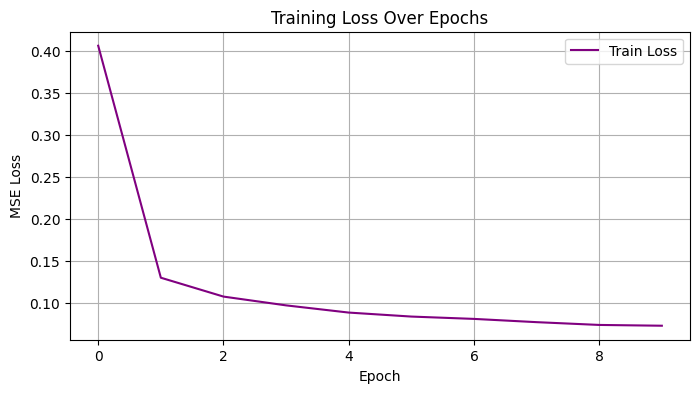

In [41]:
# ✅ 1. Imports
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import librosa
import numpy as np
import soundfile as sf
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import Audio, display

# ✅ 2. Config
sr = 16000
duration = 3.05
length = int(sr * duration)
n_fft = 512
hop_length = 128
win_length = 512

# ✅ 3. Helper - STFT magnitude
def audio_to_mag(filepath):
    y, _ = librosa.load(filepath, sr=sr)
    y = librosa.util.fix_length(data=y, size=length)
    y = y / np.max(np.abs(y))
    stft = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
    mag = np.abs(stft)
    return mag.astype(np.float32)

# ✅ 4. Dataset
class SpectrogramDataset(Dataset):
    def __init__(self, clean_files, noisy_files):
        self.clean_files = clean_files
        self.noisy_files = noisy_files

    def __len__(self):
        return len(self.clean_files)

    def __getitem__(self, idx):
        clean_mag = audio_to_mag(self.clean_files[idx])
        noisy_mag = audio_to_mag(self.noisy_files[idx])
        return torch.tensor(noisy_mag).unsqueeze(0), torch.tensor(clean_mag).unsqueeze(0)

# ✅ 5. U-Net Model
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = nn.Sequential(nn.Conv2d(1, 16, 3, padding=1), nn.ReLU())
        self.enc2 = nn.Sequential(nn.Conv2d(16, 32, 3, padding=1), nn.ReLU())
        self.enc3 = nn.Sequential(nn.Conv2d(32, 64, 3, padding=1), nn.ReLU())
        self.middle = nn.Sequential(nn.Conv2d(64, 128, 3, padding=1), nn.ReLU())
        self.dec3 = nn.Sequential(nn.Conv2d(128, 64, 3, padding=1), nn.ReLU())
        self.dec2 = nn.Sequential(nn.Conv2d(64, 32, 3, padding=1), nn.ReLU())
        self.dec1 = nn.Sequential(nn.Conv2d(32, 16, 3, padding=1), nn.ReLU())
        self.final = nn.Conv2d(16, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(F.max_pool2d(e1, 2))
        e3 = self.enc3(F.max_pool2d(e2, 2))
        m = self.middle(F.max_pool2d(e3, 2))

        d3 = self.dec3(F.interpolate(m, size=e3.shape[-2:], mode='nearest'))
        d2 = self.dec2(F.interpolate(d3 + e3, size=e2.shape[-2:], mode='nearest'))
        d1 = self.dec1(F.interpolate(d2 + e2, size=e1.shape[-2:], mode='nearest'))
        out = self.final(d1 + e1)
        return out

# ✅ 6. File Paths
clean_dir = "/kaggle/input/noise-dataset/drdo/clean_avg_fixed"
noisy_dir = "/kaggle/input/noise-dataset/drdo/mixed_dataset/noisy"

clean_files = sorted(glob(f"{clean_dir}/*.wav"))
noisy_files = sorted(glob(f"{noisy_dir}/*.wav"))

# ✅ 7. Dataset + DataLoader
dataset = SpectrogramDataset(clean_files, noisy_files)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

# ✅ 8. Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

train_losses = []

# ✅ 9. Training
for epoch in range(10):
    model.train()
    total_loss = 0
    for noisy, clean in tqdm(loader, desc=f"Epoch {epoch+1}"):
        noisy, clean = noisy.to(device), clean.to(device)
        output = model(noisy)

        # Match shape
        min_h = min(output.shape[2], clean.shape[2])
        min_w = min(output.shape[3], clean.shape[3])
        output = output[:, :, :min_h, :min_w]
        clean = clean[:, :, :min_h, :min_w]

        loss = loss_fn(output, clean)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    train_losses.append(avg_loss)
    print(f"\n✅ Epoch {epoch+1} | Avg Loss: {avg_loss:.4f}\n")

# ✅ 10. Training Loss Plot
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label='Train Loss', color='purple')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss Over Epochs")
plt.grid(True)
plt.legend()
plt.show()

# ✅ 11. Denoise Any File (function)
def denoise_file(model, noisy_file_path, save_dir="outputs"):
    os.makedirs(save_dir, exist_ok=True)

    y, _ = librosa.load(noisy_file_path, sr=sr)
    y = librosa.util.fix_length(y, length)
    y = y / np.max(np.abs(y))

    stft = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
    mag = np.abs(stft)
    phase = np.angle(stft)

    input_tensor = torch.tensor(mag).unsqueeze(0).unsqueeze(0).to(device)
    with torch.no_grad():
        out_mag = model(input_tensor).cpu().squeeze().numpy()

    out_mag = out_mag[:stft.shape[0], :stft.shape[1]]
    out_stft = out_mag * np.exp(1j * phase[:, :out_mag.shape[1]])
    out_audio = librosa.istft(out_stft, hop_length=hop_length, win_length=win_length)

    # Save and plot
    base_name = os.path.basename(noisy_file_path).replace(".wav", "_denoised.wav")
    save_path = os.path.join(save_dir, base_name)
    sf.write(save_path, out_audio, sr)

    print(f"\n🎧 Denoised file saved: {save_path}\n")
    display(Audio(save_path, rate=sr))

    # Waveform
    plt.figure(figsize=(12, 3))
    plt.plot(y, label="Noisy", alpha=0.5)
    plt.plot(out_audio, label="Denoised", alpha=0.8)
    plt.title("Waveform Comparison")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Spectrogram
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(mag, origin='lower', aspect='auto', cmap='inferno')
    plt.title("Noisy Spectrogram")
    plt.subplot(1, 2, 2)
    plt.imshow(out_mag, origin='lower', aspect='auto', cmap='inferno')
    plt.title("Denoised Spectrogram")
    plt.tight_layout()
    plt.show()

# ✅ 12. Test It
# Replace path below with any test file path
# denoise_file(model, "/kaggle/input/noise-dataset/drdo/mixed_dataset/noisy/example.wav")


In [42]:
def visualize_denoising(noisy_audio, denoised_audio, noisy_mag, denoised_mag, sr=16000):
    # ✅ 1. Waveform Comparison
    plt.figure(figsize=(12, 3))
    plt.plot(noisy_audio, label="Noisy", alpha=0.5)
    plt.plot(denoised_audio, label="Denoised", alpha=0.8)
    plt.title("Waveform Comparison")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ✅ 2. Spectrogram Comparison
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    librosa.display.specshow(librosa.amplitude_to_db(noisy_mag), sr=sr, hop_length=128, x_axis='time', y_axis='hz')
    plt.title("Noisy Spectrogram")
    plt.colorbar(format="%+2.0f dB")

    plt.subplot(1, 2, 2)
    librosa.display.specshow(librosa.amplitude_to_db(denoised_mag), sr=sr, hop_length=128, x_axis='time', y_axis='hz')
    plt.title("Denoised Spectrogram")
    plt.colorbar(format="%+2.0f dB")

    plt.tight_layout()
    plt.show()


In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
torch.save(model.state_dict(), "unet_denoiser.pth")
print(" Model saved as unet_denoiser.pth")


 Model saved as unet_denoiser.pth


In [48]:
def denoise_file(model, noisy_file_path, save_dir="outputs"):
    os.makedirs(save_dir, exist_ok=True)

    y, _ = librosa.load(noisy_file_path, sr=sr)
    y = librosa.util.fix_length(data=y, size=length)  # ✅ FIXED
    y = y / np.max(np.abs(y))

    stft = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
    mag = np.abs(stft)
    phase = np.angle(stft)

    input_tensor = torch.tensor(mag).unsqueeze(0).unsqueeze(0).to(device)
    with torch.no_grad():
        out_mag = model(input_tensor).cpu().squeeze().numpy()

    out_mag = out_mag[:stft.shape[0], :stft.shape[1]]
    out_stft = out_mag * np.exp(1j * phase[:, :out_mag.shape[1]])
    out_audio = librosa.istft(out_stft, hop_length=hop_length, win_length=win_length)

    base_name = os.path.basename(noisy_file_path).replace(".wav", "_denoised.wav")
    save_path = os.path.join(save_dir, base_name)
    sf.write(save_path, out_audio, sr)

    print(f"\n🎧 Denoised file saved: {save_path}\n")
    display(Audio(save_path, rate=sr))

    plt.figure(figsize=(12, 3))
    plt.plot(y, label="Noisy", alpha=0.5)
    plt.plot(out_audio, label="Denoised", alpha=0.8)
    plt.title("Waveform Comparison")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(mag, origin='lower', aspect='auto', cmap='inferno')
    plt.title("Noisy Spectrogram")
    plt.subplot(1, 2, 2)
    plt.imshow(out_mag, origin='lower', aspect='auto', cmap='inferno')
    plt.title("Denoised Spectrogram")
    plt.tight_layout()
    plt.show()



🎧 Denoised file saved: outputs/p226_003_gun_radio_denoised.wav



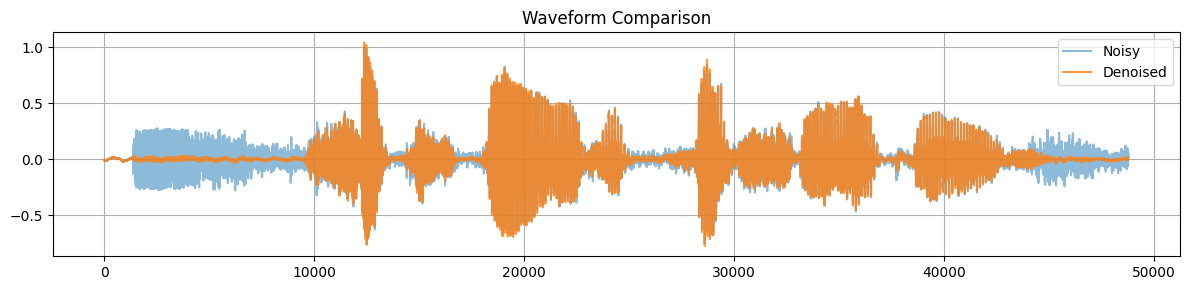

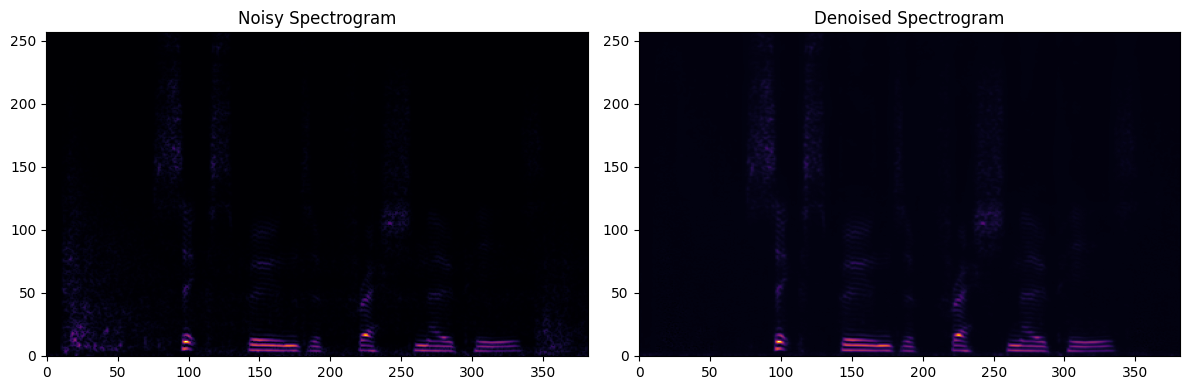

In [50]:


denoise_file(model, "/kaggle/input/noise-dataset/drdo/mixed_dataset/noisy/p226_003_gun_radio.wav")





🎧 Denoised file saved: outputs/p226_021_helicopter_radio_denoised.wav



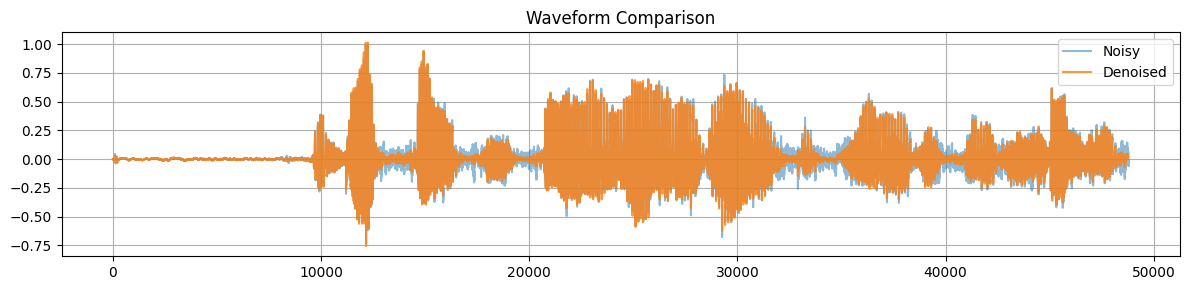

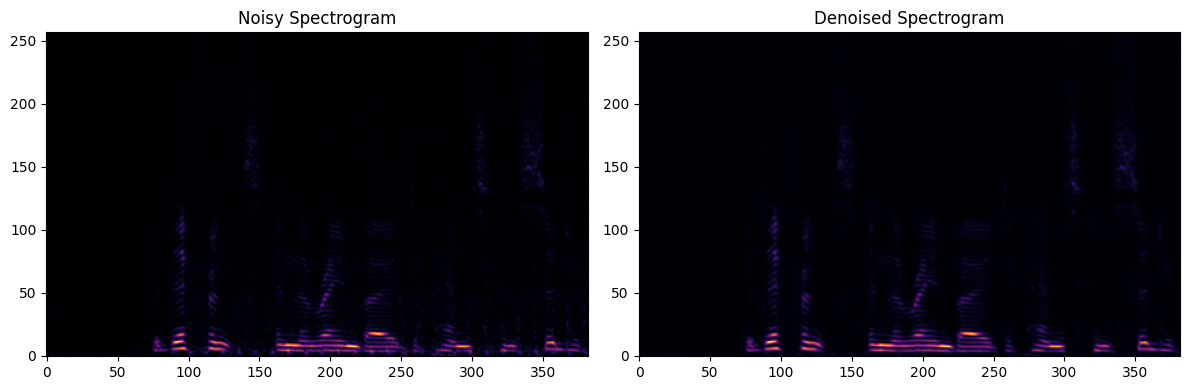

In [52]:


denoise_file(model, "/kaggle/input/noise-dataset/drdo/mixed_dataset/noisy/p226_021_helicopter_radio.wav")




In [ ]:
model = UNet().to(device)
model.load_state_dict(torch.load("unet_denoiser.pth", map_location=device))
model.eval()
print("✅ Model loaded and ready for inference!")


In [46]:
noisy_file_path = "/kaggle/input/noise-dataset/drdo/mixed_dataset/noisy/p226_003_gun_radio.wav"

# Load and run
denoise_file(model, noisy_file_path)


TypeError: fix_length() takes 1 positional argument but 2 were given

In [ ]:
import torch
import numpy as np
import librosa
import matplotlib.pyplot as plt
import librosa.display
import soundfile as sf
from IPython.display import Audio, display


In [ ]:
def visualize_denoising(noisy_audio, denoised_audio, noisy_mag, denoised_mag, sr=16000):
    # Waveform
    plt.figure(figsize=(12, 3))
    plt.plot(noisy_audio, label="Noisy", alpha=0.5)
    plt.plot(denoised_audio, label="Denoised", alpha=0.8)
    plt.title("Waveform Comparison")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Spectrogram
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    librosa.display.specshow(librosa.amplitude_to_db(noisy_mag), sr=sr, hop_length=128, x_axis='time', y_axis='hz')
    plt.title("Noisy Spectrogram")
    plt.colorbar(format="%+2.0f dB")

    plt.subplot(1, 2, 2)
    librosa.display.specshow(librosa.amplitude_to_db(denoised_mag), sr=sr, hop_length=128, x_axis='time', y_axis='hz')
    plt.title("Denoised Spectrogram")
    plt.colorbar(format="%+2.0f dB")

    plt.tight_layout()
    plt.show()


In [ ]:
def denoise_file(model, noisy_file_path, save_dir="outputs"):
    sr = 16000
    duration = 3.05
    length = int(sr * duration)
    n_fft = 512
    hop_length = 128
    win_length = 512

    os.makedirs(save_dir, exist_ok=True)

    y, _ = librosa.load(noisy_file_path, sr=sr)
    y = librosa.util.fix_length(y, size=length)
    y = y / np.max(np.abs(y))

    stft = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
    mag = np.abs(stft)
    phase = np.angle(stft)

    input_tensor = torch.tensor(mag).unsqueeze(0).unsqueeze(0).to(model.device if hasattr(model, "device") else "cpu")
    with torch.no_grad():
        out_mag = model(input_tensor).cpu().squeeze().numpy()

    out_mag = out_mag[:stft.shape[0], :stft.shape[1]]
    out_stft = out_mag * np.exp(1j * phase[:, :out_mag.shape[1]])
    out_audio = librosa.istft(out_stft, hop_length=hop_length, win_length=win_length)

    # Save
    base_name = os.path.basename(noisy_file_path).replace(".wav", "_denoised.wav")
    save_path = os.path.join(save_dir, base_name)
    sf.write(save_path, out_audio, sr)
    print(f"✅ Denoised audio saved at: {save_path}")
    display(Audio(save_path, rate=sr))

    # 🔍 VISUALIZE
    visualize_denoising(y, out_audio, mag, out_mag)


In [ ]:
denoise_file(model, "/kaggle/input/noise-dataset/drdo/mixed_dataset/noisy/p226_003_gun_radio.wav")


In [16]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import librosa
import numpy as np
import soundfile as sf
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import Audio, display


In [17]:
sr = 16000
duration = 3.05
length = int(sr * duration)
n_fft = 512
hop_length = 128
win_length = 512


In [18]:
def audio_to_mag(filepath):
    y, _ = librosa.load(filepath, sr=sr)
    y = librosa.util.fix_length(data=y, size=length)
    y = y / np.max(np.abs(y))
    stft = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
    mag = np.abs(stft)
    return mag.astype(np.float32)


In [19]:
class SpectrogramDataset(Dataset):
    def __init__(self, clean_files, noisy_files):
        self.clean_files = clean_files
        self.noisy_files = noisy_files

    def __len__(self):
        return len(self.clean_files)

    def __getitem__(self, idx):
        clean_mag = audio_to_mag(self.clean_files[idx])
        noisy_mag = audio_to_mag(self.noisy_files[idx])
        return torch.tensor(noisy_mag).unsqueeze(0), torch.tensor(clean_mag).unsqueeze(0)


In [20]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = nn.Sequential(nn.Conv2d(1, 16, 3, padding=1), nn.ReLU())
        self.enc2 = nn.Sequential(nn.Conv2d(16, 32, 3, padding=1), nn.ReLU())
        self.enc3 = nn.Sequential(nn.Conv2d(32, 64, 3, padding=1), nn.ReLU())
        self.middle = nn.Sequential(nn.Conv2d(64, 128, 3, padding=1), nn.ReLU())
        self.dec3 = nn.Sequential(nn.Conv2d(128, 64, 3, padding=1), nn.ReLU())
        self.dec2 = nn.Sequential(nn.Conv2d(64, 32, 3, padding=1), nn.ReLU())
        self.dec1 = nn.Sequential(nn.Conv2d(32, 16, 3, padding=1), nn.ReLU())
        self.final = nn.Conv2d(16, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(F.max_pool2d(e1, 2))
        e3 = self.enc3(F.max_pool2d(e2, 2))
        m = self.middle(F.max_pool2d(e3, 2))
        d3 = self.dec3(F.interpolate(m, size=e3.shape[-2:], mode='nearest'))
        d2 = self.dec2(F.interpolate(d3 + e3, size=e2.shape[-2:], mode='nearest'))
        d1 = self.dec1(F.interpolate(d2 + e2, size=e1.shape[-2:], mode='nearest'))
        out = self.final(d1 + e1)
        return out


In [21]:
clean_dir = "/kaggle/input/noise-dataset/drdo/clean_avg_fixed"
noisy_dir = "/kaggle/input/noise-dataset/drdo/mixed_dataset/noisy"
clean_files = sorted(glob(f"{clean_dir}/*.wav"))
noisy_files = sorted(glob(f"{noisy_dir}/*.wav"))


In [22]:
dataset = SpectrogramDataset(clean_files, noisy_files)
loader = DataLoader(dataset, batch_size=4, shuffle=True)


In [23]:
def compute_snr(clean, denoised):
    noise = clean - denoised
    return 10 * np.log10(np.sum(clean**2) / np.sum(noise**2) + 1e-8)

def compute_psnr(clean, denoised):
    mse = np.mean((clean - denoised) ** 2)
    max_val = np.max(clean)
    return 20 * np.log10(max_val / np.sqrt(mse + 1e-8))

def compute_lsd(clean_mag, denoised_mag):
    return np.mean(np.sqrt(np.mean((20 * np.log10(clean_mag + 1e-8) - 20 * np.log10(denoised_mag + 1e-8))**2, axis=0)))


In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet_model = UNet().to(device)
optimizer = torch.optim.Adam(unet_model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
train_losses = []
train_psnrs = []


In [26]:
for epoch in range(1, 27):
    unet_model.train()
    total_loss = 0
    total_psnr = 0

    for noisy, clean in tqdm(loader, desc=f"Epoch {epoch}"):
        noisy, clean = noisy.to(device), clean.to(device)
        output = unet_model(noisy)

        min_h = min(output.shape[2], clean.shape[2])
        min_w = min(output.shape[3], clean.shape[3])
        output = output[:, :, :min_h, :min_w]
        clean = clean[:, :, :min_h, :min_w]

        loss = loss_fn(output, clean)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_psnr += compute_psnr(clean.cpu().numpy(), output.detach().cpu().numpy())

    avg_loss = total_loss / len(loader)
    avg_psnr = total_psnr / len(loader)
    train_losses.append(avg_loss)
    train_psnrs.append(avg_psnr)

    print(f"\n✅ Epoch {epoch} | Avg Loss: {avg_loss:.4f} | Avg PSNR: {avg_psnr:.2f} dB\n")


Epoch 1: 100%|██████████| 473/473 [05:34<00:00,  1.42it/s]



✅ Epoch 1 | Avg Loss: 0.2745 | Avg PSNR: 43.15 dB



Epoch 2: 100%|██████████| 473/473 [05:33<00:00,  1.42it/s]



✅ Epoch 2 | Avg Loss: 0.1120 | Avg PSNR: 46.29 dB



Epoch 3: 100%|██████████| 473/473 [05:34<00:00,  1.41it/s]



✅ Epoch 3 | Avg Loss: 0.0944 | Avg PSNR: 47.00 dB



Epoch 4: 100%|██████████| 473/473 [05:33<00:00,  1.42it/s]



✅ Epoch 4 | Avg Loss: 0.0908 | Avg PSNR: 47.21 dB



Epoch 5: 100%|██████████| 473/473 [05:33<00:00,  1.42it/s]



✅ Epoch 5 | Avg Loss: 0.0834 | Avg PSNR: 47.52 dB



Epoch 6: 100%|██████████| 473/473 [05:35<00:00,  1.41it/s]



✅ Epoch 6 | Avg Loss: 0.0780 | Avg PSNR: 47.85 dB



Epoch 7: 100%|██████████| 473/473 [05:34<00:00,  1.42it/s]



✅ Epoch 7 | Avg Loss: 0.0757 | Avg PSNR: 47.97 dB



Epoch 8: 100%|██████████| 473/473 [05:33<00:00,  1.42it/s]



✅ Epoch 8 | Avg Loss: 0.0725 | Avg PSNR: 48.10 dB



Epoch 9: 100%|██████████| 473/473 [05:35<00:00,  1.41it/s]



✅ Epoch 9 | Avg Loss: 0.0701 | Avg PSNR: 48.28 dB



Epoch 10: 100%|██████████| 473/473 [05:33<00:00,  1.42it/s]



✅ Epoch 10 | Avg Loss: 0.0684 | Avg PSNR: 48.45 dB



Epoch 11: 100%|██████████| 473/473 [05:33<00:00,  1.42it/s]



✅ Epoch 11 | Avg Loss: 0.0660 | Avg PSNR: 48.52 dB



Epoch 12: 100%|██████████| 473/473 [05:37<00:00,  1.40it/s]



✅ Epoch 12 | Avg Loss: 0.0670 | Avg PSNR: 48.48 dB



Epoch 13: 100%|██████████| 473/473 [05:34<00:00,  1.41it/s]



✅ Epoch 13 | Avg Loss: 0.0697 | Avg PSNR: 48.33 dB



Epoch 14: 100%|██████████| 473/473 [05:36<00:00,  1.41it/s]



✅ Epoch 14 | Avg Loss: 0.0627 | Avg PSNR: 48.74 dB



Epoch 15: 100%|██████████| 473/473 [05:34<00:00,  1.41it/s]



✅ Epoch 15 | Avg Loss: 0.0612 | Avg PSNR: 48.85 dB



Epoch 16: 100%|██████████| 473/473 [05:36<00:00,  1.40it/s]



✅ Epoch 16 | Avg Loss: 0.0594 | Avg PSNR: 48.92 dB



Epoch 17: 100%|██████████| 473/473 [05:36<00:00,  1.41it/s]



✅ Epoch 17 | Avg Loss: 0.0600 | Avg PSNR: 48.91 dB



Epoch 18: 100%|██████████| 473/473 [05:31<00:00,  1.43it/s]



✅ Epoch 18 | Avg Loss: 0.0588 | Avg PSNR: 49.07 dB



Epoch 19: 100%|██████████| 473/473 [05:32<00:00,  1.42it/s]



✅ Epoch 19 | Avg Loss: 0.0578 | Avg PSNR: 49.13 dB



Epoch 20: 100%|██████████| 473/473 [05:32<00:00,  1.42it/s]



✅ Epoch 20 | Avg Loss: 0.0577 | Avg PSNR: 49.07 dB



Epoch 21: 100%|██████████| 473/473 [05:34<00:00,  1.41it/s]



✅ Epoch 21 | Avg Loss: 0.0562 | Avg PSNR: 49.21 dB



Epoch 22: 100%|██████████| 473/473 [05:33<00:00,  1.42it/s]



✅ Epoch 22 | Avg Loss: 0.0554 | Avg PSNR: 49.27 dB



Epoch 23: 100%|██████████| 473/473 [05:35<00:00,  1.41it/s]



✅ Epoch 23 | Avg Loss: 0.0574 | Avg PSNR: 49.17 dB



Epoch 24: 100%|██████████| 473/473 [05:33<00:00,  1.42it/s]



✅ Epoch 24 | Avg Loss: 0.0541 | Avg PSNR: 49.45 dB



Epoch 25: 100%|██████████| 473/473 [05:35<00:00,  1.41it/s]



✅ Epoch 25 | Avg Loss: 0.0549 | Avg PSNR: 49.32 dB



Epoch 26: 100%|██████████| 473/473 [05:32<00:00,  1.42it/s]


✅ Epoch 26 | Avg Loss: 0.0538 | Avg PSNR: 49.39 dB



In [27]:
# Save the model after training
torch.save(unet_model.state_dict(), "unet_model_noise_cancellation.pth")
print("✅ Model saved successfully!")


✅ Model saved successfully!


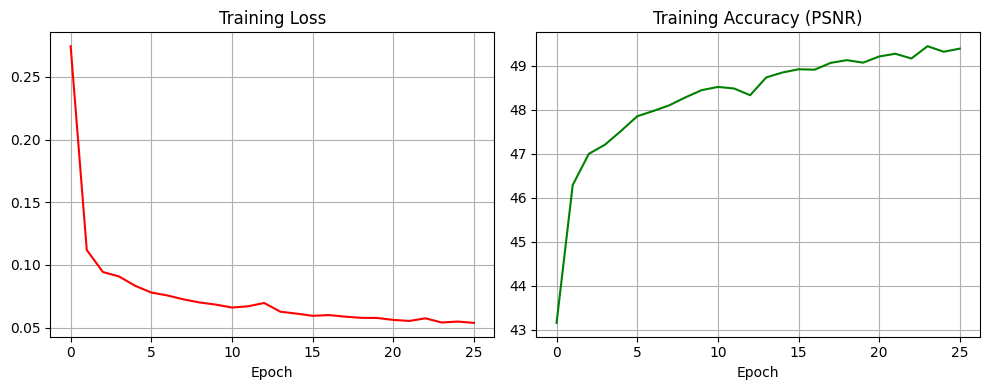

In [28]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Loss', color='red')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_psnrs, label='PSNR (Accuracy)', color='green')
plt.title("Training Accuracy (PSNR)")
plt.xlabel("Epoch")
plt.grid(True)

plt.tight_layout()
plt.show()


In [30]:
def denoise_file_with_metrics(model, noisy_file_path, save_dir="outputs"):
    os.makedirs(save_dir, exist_ok=True)

    y, _ = librosa.load(noisy_file_path, sr=sr)
    y = librosa.util.fix_length(y, length)
    y = y / np.max(np.abs(y))

    stft = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
    mag = np.abs(stft)
    phase = np.angle(stft)

    input_tensor = torch.tensor(mag).unsqueeze(0).unsqueeze(0).to(device)
    with torch.no_grad():
        out_mag = model(input_tensor).cpu().squeeze().numpy()

    out_mag = out_mag[:stft.shape[0], :stft.shape[1]]
    out_stft = out_mag * np.exp(1j * phase[:, :out_mag.shape[1]])
    out_audio = librosa.istft(out_stft, hop_length=hop_length, win_length=win_length)

    base_name = os.path.basename(noisy_file_path).replace(".wav", "_denoised.wav")
    save_path = os.path.join(save_dir, base_name)
    sf.write(save_path, out_audio, sr)

    clean_path = noisy_file_path.replace("mixed_dataset/noisy", "clean_avg_fixed")
    y_clean, _ = librosa.load(clean_path, sr=sr)
    y_clean = librosa.util.fix_length(y_clean, length)
    y_clean = y_clean / np.max(np.abs(y_clean))

    min_len = min(len(y_clean), len(out_audio))
    y_clean = y_clean[:min_len]
    out_audio = out_audio[:min_len]

    snr = compute_snr(y_clean, out_audio)
    psnr = compute_psnr(y_clean, out_audio)

    clean_mag = np.abs(librosa.stft(y_clean, n_fft=n_fft, hop_length=hop_length, win_length=win_length))
    denoised_mag = np.abs(librosa.stft(out_audio, n_fft=n_fft, hop_length=hop_length, win_length=win_length))
    lsd = compute_lsd(clean_mag, denoised_mag)

    print(f"\n📊 Evaluation Metrics for: {base_name}")
    print(f"🔸 SNR:  {snr:.2f} dB")
    print(f"🔸 PSNR: {psnr:.2f} dB")
    print(f"🔸 LSD:  {lsd:.4f}")

    display(Audio(save_path, rate=sr))

    plt.figure(figsize=(12, 3))
    plt.plot(y, label="Noisy", alpha=0.5)
    plt.plot(out_audio, label="Denoised", alpha=0.8)
    plt.legend(); plt.grid(); plt.title("Waveform"); plt.tight_layout(); plt.show()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(mag, origin='lower', aspect='auto', cmap='inferno')
    plt.title("Noisy Spectrogram")
    plt.subplot(1, 2, 2)
    plt.imshow(out_mag, origin='lower', aspect='auto', cmap='inferno')
    plt.title("Denoised Spectrogram")
    plt.tight_layout()
    plt.show()


In [35]:
def denoise_file_with_metrics(model, noisy_file_path, save_dir="/kaggle/working/denoised_outputs"):
    os.makedirs(save_dir, exist_ok=True)

    sr = 16000
    length = 32000  # 2 seconds of audio at 16kHz
    y, _ = librosa.load(noisy_file_path, sr=sr)

    # Fix audio length properly
    y = librosa.util.fix_length(y, size=length)
    y = y / np.max(np.abs(y))

    noisy_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(noisy_tensor)
    
    output_np = output.cpu().squeeze().numpy()
    
    # Save denoised output
    out_path = os.path.join(save_dir, os.path.basename(noisy_file_path).replace(".wav", "_denoised.wav"))
    sf.write(out_path, output_np, sr)

    print(f"✅ Denoised file saved at: {out_path}")
    
    # Optional: Add SNR or evaluation metrics here


In [39]:
import numpy as np

def compute_psnr(clean, denoised):
    mse = np.mean((clean - denoised) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(1.0 / np.sqrt(mse))

def compute_snr(clean, denoised):
    signal_power = np.mean(clean ** 2)
    noise_power = np.mean((clean - denoised) ** 2)
    if noise_power == 0:
        return 100
    return 10 * np.log10(signal_power / noise_power)
